In [ ]:
import pathlib, os,sys, cv2
import tensorflow as tf
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import tensorflow_hub as hub

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers




Mounted at /content/drive


In [ ]:
dataset = "drive/My Drive/archive/Covid19-dataset/"


In [ ]:
#OS directory 
train_dir  = os.path.join(dataset,'train')
validation_dir = os.path.join(dataset,'test')

#Directory with the covid/normal/viral pneumonia
train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

test_covid_dir = os.path.join(validation_dir, 'Covid')
test_normal_dir = os.path.join(validation_dir, 'Normal')
test_pneumonia_dir = os.path.join(validation_dir, 'Viral Pneumonia')



In [ ]:
len_train_set = len(os.listdir(train_covid_dir)) + len(os.listdir( train_normal_dir))+ len(os.listdir( train_pneumonia_dir))
len_test_set = len(os.listdir(test_covid_dir)) + len(os.listdir( test_normal_dir))+ len(os.listdir( test_pneumonia_dir))
total_len = len_train_set + len_test_set

print('total training :', len_train_set )
print('total validation :', len_test_set )


total training : 251
total validation : 66


In [ ]:
def process_images_train(dir):

   rescaler = ImageDataGenerator(
      rescale = 1.0/255.,
      shear_range = 0.2,
      zoom_range = 0.2,
      fill_mode = 'nearest'    )
   
   processed_images = rescaler.flow_from_directory(
      dir,
      target_size = (224,224),
      follow_links = False,
      batch_size = 32
   
      )
   return processed_images
def process_images_validate(dir):

   rescaler = ImageDataGenerator(
      rescale = 1.0/255.,
      shear_range = 0.2,
      zoom_range = 0.2,
      fill_mode = 'nearest'
      )
   
   processed_images = rescaler.flow_from_directory(
      dir,
      target_size = (224,224),
      follow_links = True,
      batch_size = 32, 
      
      shuffle = False, 
      )
   return processed_images
train_data = process_images_train(train_dir)
test_data = process_images_validate(validation_dir)


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [ ]:
IMG_SHAPE =(224,224)
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2' 

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMG_SHAPE+(3, )) # Channel 3 RGB
])

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


16384/10484 [==============================================] - 0s 0us/step


In [ ]:
for image_batch, label_batch in test_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


Batch result shape: (32, 1001)
Batch predicted class names: ['mask' 'quill' 'isopod' 'isopod' 'isopod' 'trilobite' 'trilobite'
 'fur coat' 'fountain' 'mask' 'fountain' 'quill' 'isopod' 'trilobite'
 'geyser' 'plastic bag' 'fountain' 'radiator' 'volcano' 'cliff'
 'trilobite' 'trilobite' 'isopod' 'fur coat' 'isopod' 'quill'
 'water bottle' 'trilobite' 'trilobite' 'isopod' 'lotion' 'water bottle']


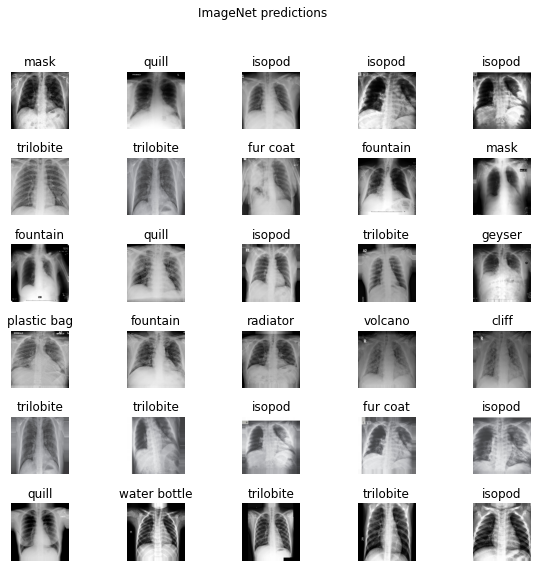

In [ ]:
result_batch = classifier.predict(image_batch)
print(f'Batch result shape: {result_batch.shape}')

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(f'Batch predicted class names: {predicted_class_names}')

fig1 = plt.figure(figsize=(10, 9))
fig1.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig1.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    ax.set_title(predicted_class_names[n])
    ax.axis('off')
_ = fig1.suptitle('ImageNet predictions')

In [ ]:
# Prepare transfer learning
## Download headless (without the top classification layer) model
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2' #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMG_SHAPE+(3, ))
feature_batch = feature_extractor_layer(image_batch)
print(f'Feature vector shape: {feature_batch.shape}')

## Frozen feature extraction layer
feature_extractor_layer.trainable = False # for transfer learning classifier

## Make a model for classification
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(train_data.num_classes, activation='softmax')
])

Feature vector shape: (32, 1280)


In [ ]:
## Check the model and prediction result
model.summary()

predictions = model(image_batch)
print(f'Prediction shape: {predictions.shape}')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Prediction shape: (32, 3)


In [ ]:
# Train build
## Compile model for train
base_learning_rate = 0.001 # default
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

## Log class
### https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_val_losses = []
        self.batch_acc = []
        self.batch_val_acc = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.batch_val_losses.append(logs['val_loss'])
        self.batch_val_acc.append(logs['val_accuracy'])
        self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size) # train all dataset per epoch
initial_epoch = 5
batch_stats_callback = CollectBatchStats()

history = model.fit(train_data,
                    epochs=initial_epoch,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_data,
                    callbacks=[batch_stats_callback])

Epoch 1/5
8/8 [==============================] - 21s 3s/step - loss: 0.8401 - accuracy: 0.7012 - val_loss: 0.8441 - val_accuracy: 0.6818
Epoch 2/5
8/8 [==============================] - 21s 3s/step - loss: 0.7531 - accuracy: 0.8367 - val_loss: 0.8010 - val_accuracy: 0.7879
Epoch 3/5
8/8 [==============================] - 22s 3s/step - loss: 0.7349 - accuracy: 0.8805 - val_loss: 0.7927 - val_accuracy: 0.7576
Epoch 4/5
8/8 [==============================] - 21s 3s/step - loss: 0.7174 - accuracy: 0.8725 - val_loss: 0.7357 - val_accuracy: 0.8333
Epoch 5/5
8/8 [==============================] - 21s 3s/step - loss: 0.6828 - accuracy: 0.9084 - val_loss: 0.7276 - val_accuracy: 0.8333


In [ ]:
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')
